# PhysicsNeMo Tutorial

### 실습 예제 목록
##### 1. 1D Regression
##### 2. 2D Regression
##### 3. Boundary Value Problem : Poisson
##### 4. Burgers Equation
##### 5. 1D Wave Equation
##### 6. Lid Driven Cavity

# PhysicsNeMo 학습 코드 Flow

### PhysicsNeMo 학습 코드는 다음과 같은 Flow를 따릅니다.
#### 1. Define : Problem
#### 2. Load : Configuration
- 모델 학습 hyperparameter, optimizer등 setting을 저장

#### 3. Define : Geometry, Dataset, Model
- 데이터셋과 모델을 정의

#### 4. Define : Node -> Constraint -> Domain
- solver에 전달할 domain을 정의

#### 5. Create : Solver
- solver에 configuration 파일과 domain을 전달
- solver를 통해 학습

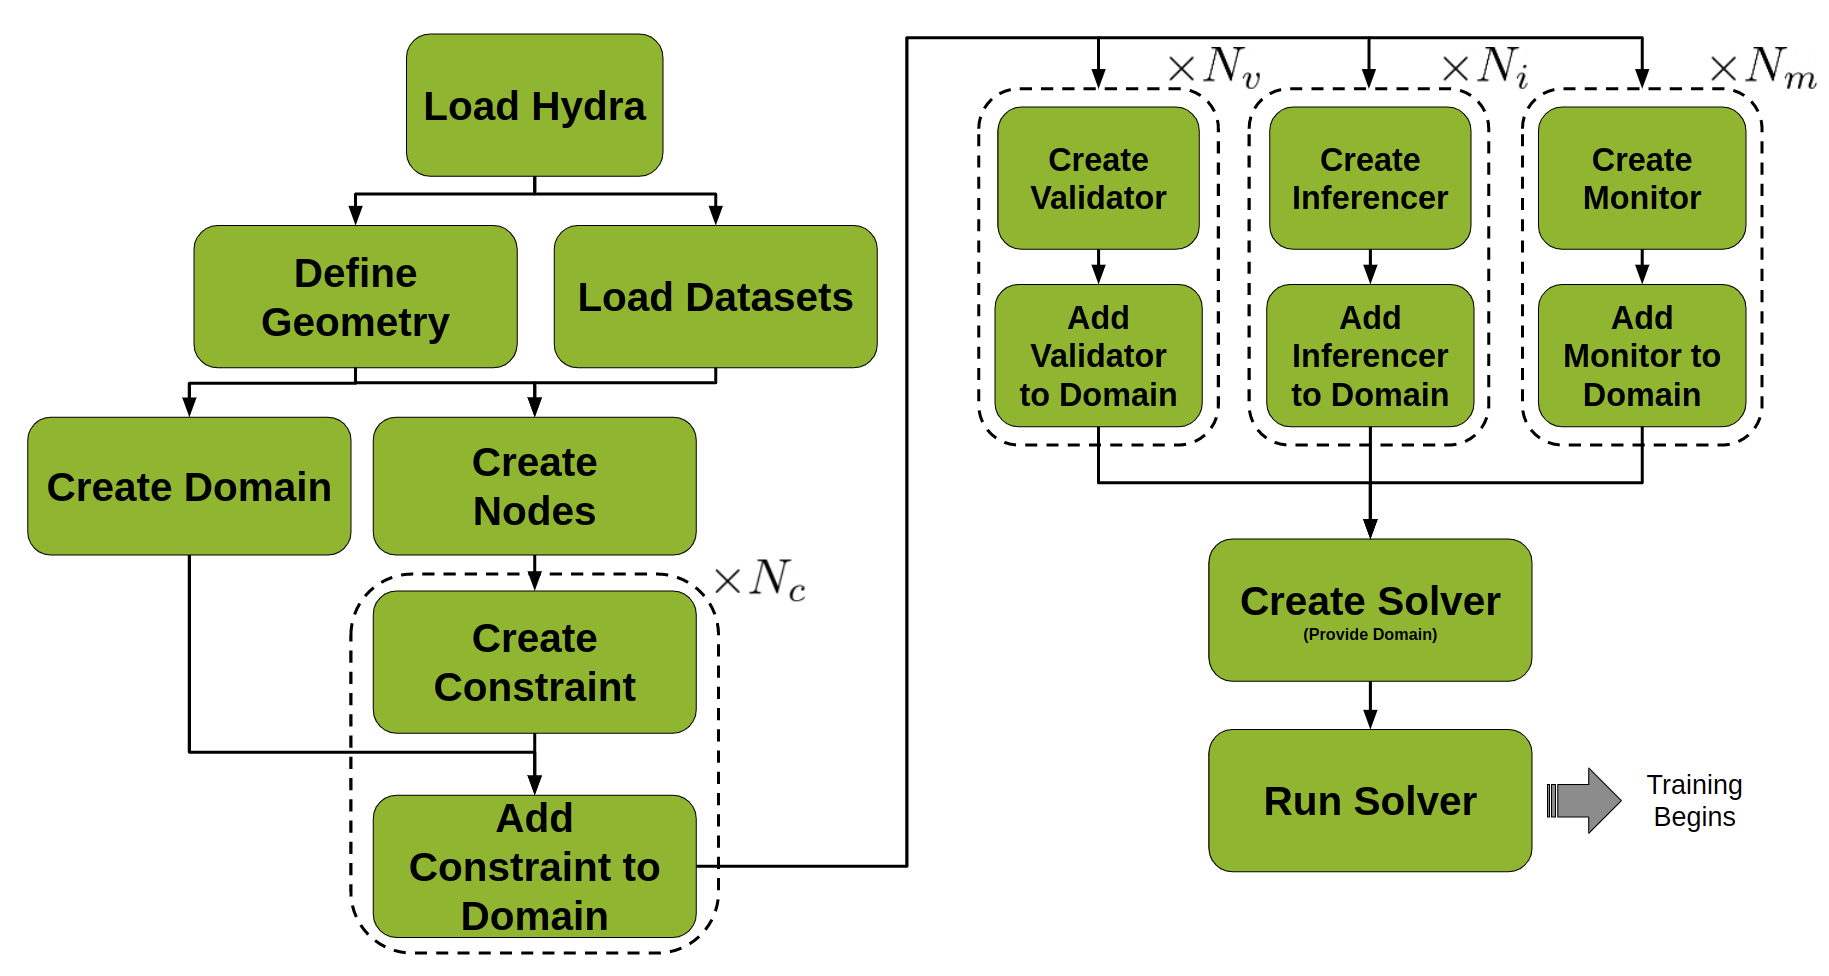

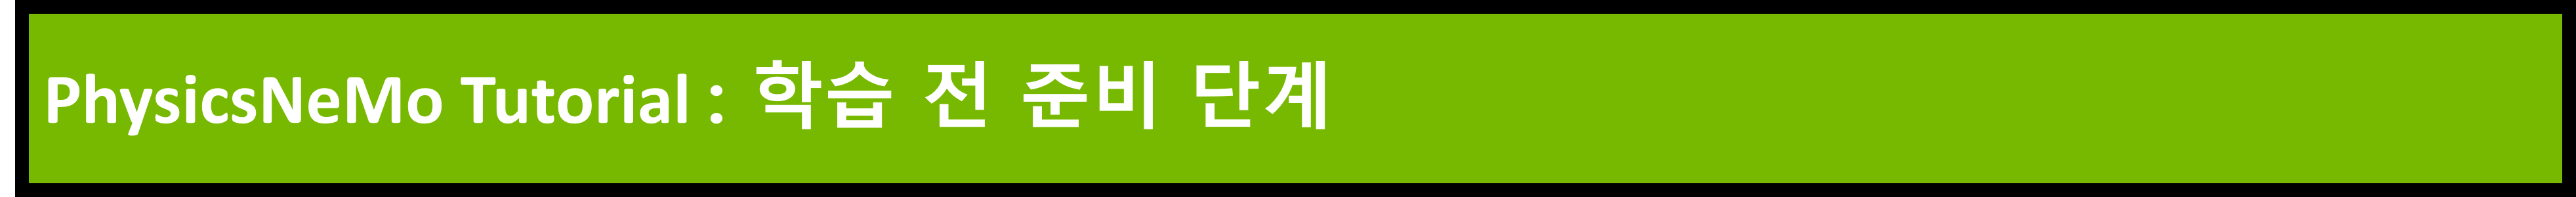

### 라이브러리 설치

In [1]:
!pip uninstall -y nvidia-physicsnemo fsspec s3fs
!pip install "fsspec==2025.3.0" "s3fs==2025.3.0" "gcsfs==2025.3.0" "jedi>=0.16"
!pip install --no-deps "nvidia-physicsnemo==1.2.0"
!pip install -U hydra-core==1.3.2 omegaconf==2.3.0
!pip install mlflow
!pip install nvidia-physicsnemo-sym --no-build-isolation
#!pip install --no-deps "nvidia-physicsnemo-sym==2.2.0"

Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.0/806.0 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
# NVIDIA DALI 자동 설치 (CUDA 버전 감지 → 맞는 휠 설치)
import re, sys, subprocess

def detect_cuda_major():
    # 1) PyTorch가 있으면 그 버전으로 우선 판별
    try:
        import torch
        v = torch.version.cuda or ""
        m = re.match(r"(\d+)\.(\d+)", v)
        if m:
            return int(m.group(1))
    except Exception:
        pass
    # 2) nvidia-smi 출력에서 "CUDA Version: xx.x" 파싱 (드라이버 기준)
    try:
        out = subprocess.check_output(["nvidia-smi"], text=True, stderr=subprocess.STDOUT)
        m = re.search(r"CUDA Version:\s*([0-9]+)\.", out)
        if m:
            return int(m.group(1))
    except Exception:
        pass
    return 12  # Colab 기본 가정 (12.x)

major = detect_cuda_major()
if   major >= 13: pkg = "nvidia-dali-cuda130"
elif major == 12: pkg = "nvidia-dali-cuda120"
elif major == 11: pkg = "nvidia-dali-cuda110"
else:             pkg = "nvidia-dali-cuda120"  # 합리적 기본값

print(f"Installing: {pkg}")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg])

# 설치 확인
import nvidia.dali as dali
print("DALI OK — version:", dali.__version__)

Installing: nvidia-dali-cuda120
DALI OK — version: 1.52.0


In [3]:
!git clone https://github.com/heechangkim/physicsnemo_tutorial.git

Cloning into 'physicsnemo_tutorial'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 124 (delta 11), reused 33 (delta 9), pack-reused 86 (from 1)
Receiving objects: 100% (124/124), 235.15 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (56/56), done.


In [4]:
# --- 강제 로깅 초기화(중복 핸들러 방지, 레벨 보장) ---
import logging
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(name)s: %(message)s', force=True)
for name in ["physicsnemo", "physicsnemo.sym", "physicsnemo.sym.trainer"]:
    logging.getLogger(name).setLevel(logging.INFO)

In [5]:
from hydra.utils import to_absolute_path
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, open_dict

%cd /content/physicsnemo_tutorial/PINNs/basic_examples/conf/
%mkdir /tmp/conf

/content/physicsnemo_tutorial/PINNs/basic_examples/conf


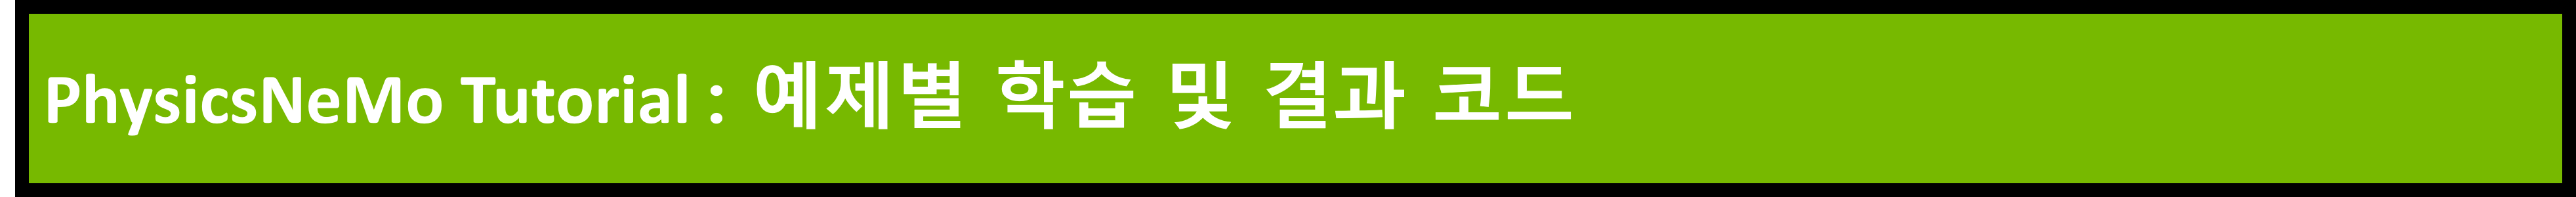

# 1D Function Regression Problem
다음의 1차원 함수에 대해 Regression 문제를 해결합니다.
$$u(x) = 5\sin(\pi x) +\sin(8\pi x)+0.5\sin(16\pi x),x\in[-1,1].$$
Given a set of N training data ${x_i, u_i}_{i=1}^N$ where $u_i=u(x_i)$, train a neural network to approximate $u(x)$.

이 예제는 다음 내용을 실습합니다.
- PhysicsNeMo 모델 학습 Workflow (기본)
- Spectral bias
- Fourier Feature Embedding method의 학습 가속 효과


### Define Problem

In [6]:
import os, math, time, random
import numpy as np
import torch
import matplotlib.pyplot as plt
from omegaconf import open_dict
random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

### function u(x)

In [7]:
def target_function_np(x: np.ndarray) -> np.ndarray:
    return 5*np.sin(np.pi*x) + np.sin(8*np.pi*x) + 0.5*np.sin(16*np.pi*x)

### Load Configuration

In [8]:
# 1D Regression 학습 hyperparameter setting 파일(configuration 파일) 불러오기
%cp config_1D_Regression.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_1D_Regression"
cfg = compose(config_name=config_name)

##### configuration 파일 확인

In [9]:
from physicsnemo.sym.models.activation import Activation

[INFO] numexpr.utils: NumExpr defaulting to 2 threads.


### configuration setting 변경 가능
- max_steps : 총 학습 횟수
- layer_size : 네트워크 너비
- nr_layers : 네트워크 layer 개수
- actv_fn : activation function

In [10]:
with open_dict(cfg):
    # configuration hyperparameter setting 변경 가능
    cfg.training.max_steps = 10000
    cfg.training.print_stats_freq = 100
    cfg.arch.fully_connected.layer_size = 512
    cfg.arch.fully_connected.nr_layers = 6
    # keep LR constant (match original 1D regression meaning)
    if "scheduler" in cfg and "decay_rate" in cfg.scheduler:
        cfg.scheduler.decay_rate = 1.0
print(OmegaConf.to_yaml(cfg))

actv_fn = Activation.TANH ## TANH, SILU, SIN, RELU, GELU, LEAKY_RELU, ...

training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 1000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  grad_clip_max_norm: 0.5
  monitor_grad_clip: true
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
amp:
  enabled: false
  mode: per_order_scaler
  dtype: float16
  autocast_activation: false
  autocast_firstlayer: false
  default_max_scale_log2: 0
  custom_max_scales_log2: {}
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs_regression_1d
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: 'off'
jit: false
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_

### Define Geometry, Dataset, Model

##### Dataset

In [11]:
# cfg.data.* 사용 (없으면 기본값으로 대체)

# x 범위 설정
x_min = float(getattr(getattr(cfg, "data", {}), "x_min", -1.0))
x_max = float(getattr(getattr(cfg, "data", {}), "x_max",  1.0))

# training data, test data point 개수 설정
num_train = int(getattr(getattr(cfg, "data", {}), "num_train", 100))
num_test  = int(getattr(getattr(cfg, "data", {}), "num_test",  1000))

# train dataset 생성
x_train = np.linspace(x_min, x_max, num_train, dtype=np.float32)
y_train = target_function_np(x_train).astype(np.float32)

# test dataset 생성
x_test  = np.linspace(x_min, x_max, num_test,  dtype=np.float32)
y_test  = target_function_np(x_test).astype(np.float32)

invar_train = {"x": x_train.reshape(-1,1)}
outvar_train = {"u": y_train.reshape(-1,1)}
invar_test  = {"x": x_test.reshape(-1,1)}

dataset_size = invar_train["x"].shape[0]   # = num_train
bs_cfg = getattr(getattr(cfg, "batch_size", {}), "data", dataset_size)
batch_size_data = int(max(1, min(bs_cfg, dataset_size)))
print(f"[check] dataset_size={dataset_size}, batch_size_data={batch_size_data}")
assert batch_size_data <= dataset_size, "batch_size.data must be <= num_train"

[check] dataset_size=100, batch_size_data=100


##### Model

In [12]:
from physicsnemo.sym.key import Key
from physicsnemo.sym.models.fully_connected import FullyConnectedArch

- physicsnemo의 fullyconnected MLP architecture를 불러와서 사용합니다.

In [13]:
# network 생성 함수
def _new_baseline_net():
    return FullyConnectedArch(
        input_keys=[Key("x")],
        output_keys=[Key("u")],
        nr_layers=2,
        layer_size=50,
        activation_fn=actv_fn,
    )

In [14]:
# network 저장 경로 설정
with open_dict(cfg):
    cfg.network_dir = os.path.join("outputs", "baseline")  # 하위 폴더 구분
net = _new_baseline_net()

## 실험 1 Baseline

In [15]:
from physicsnemo.sym.domain.constraint import PointwiseConstraint
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.solver import Solver

### Define Node, Constraint, Domain

##### Node : Network 등록

In [16]:
nodes = [net.make_node(name="u_network")]

##### 학습 constraint 정의 : node, dataset를 같이 묶음

In [17]:
data_con = PointwiseConstraint.from_numpy(
    nodes=nodes, invar=invar_train, outvar=outvar_train, batch_size=batch_size_data
)

##### Domain에 Constraint를 등록

In [18]:
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

##### solver에 다음을 전달
##### - cfg : 모델 학습 설정 파일
##### - domain : constraint(node,dataset)

In [19]:
slv = Solver(cfg, domain)
slv.solve()

/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/baseline
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  5.132e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/baseline
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  9.066e+02
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  1.924e+02, time/iteration:  3.729e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  9.114e+01, time/iteration:  3.708e+00 ms


### 학습 결과

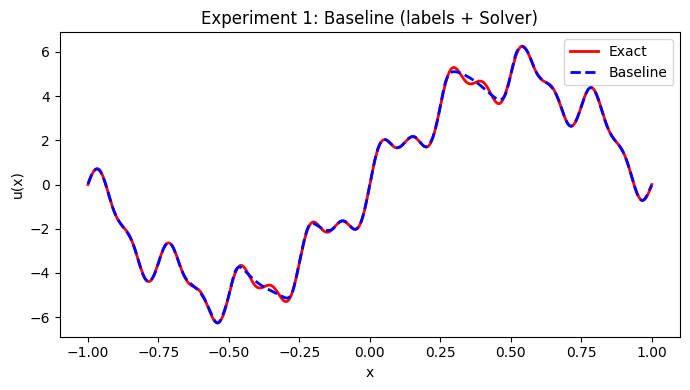

In [20]:
# 체크포인트 로드 & 예측
import torch

# 예측용 네트워크 생성
net_star = _new_baseline_net()

# 저장된 학습 모델 불러오기 (ckpt : 체크포인트)
ckpt_path = os.path.join(cfg.network_dir, "u_network.0.pth")
net_star.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
net_star.eval()
with torch.no_grad():
    pred_baseline = net_star({"x": torch.from_numpy(invar_test["x"]).float()})["u"].cpu().numpy().reshape(-1)

# 플롯 : exact solution과 모델 예측 결과 비교
plt.figure(figsize=(7,4))
plt.plot(x_test, y_test, 'r', lw=2, label='Exact')
plt.plot(x_test, pred_baseline, 'b--', lw=2, label='Baseline')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Experiment 1: Baseline (labels + Solver)')
plt.legend(); plt.tight_layout(); plt.show()

## 실험 2 Spectral bias

##### spectral bias를 확인하기 위한 실험

In [ ]:
import os, torch

save_steps = [1000, 3000, 10000]
preds_spec = {}

for steps in save_steps:
    random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

    # 3가지 실험 진행, 각 실험마다 세팅 진행
    with open_dict(cfg):
        cfg.training.max_steps = int(steps)
        cfg.network_dir = os.path.join("outputs", f"spectral_{steps}")

    # 모델 선언
    net = _new_baseline_net()

    # nodes/domain/constraint
    ### node에 모델 등록
    nodes = [net.make_node("u_network")]
    ### 빈 도메인 생성
    domain = Domain()
    ### constraint 생성 - node 정보 전달
    data_con = PointwiseConstraint.from_numpy(
        nodes=nodes, invar=invar_train, outvar=outvar_train, batch_size=batch_size_data
    )
    ### domain에 constraint 등록
    domain.add_constraint(data_con, "data")

    # Solver 생성 - 모델 설정 파일인 cfg(configuration)와 앞서 선언한 domain을 전달
    slv = Solver(cfg, domain)
    slv.solve()

    # 모델 prediction 진행
    ckpt_path = os.path.join(cfg.network_dir, "u_network.0.pth")
    if not os.path.exists(ckpt_path):
        print(f"[warn] checkpoint not found at {ckpt_path} (skip {steps})")
        continue

    net_eval = _new_baseline_net()
    net_eval.load_state_dict(torch.load(ckpt_path, map_location="cpu"))

    # 모델 학습하지 않고 출력만 진행하는 모드 : .eval()
    net_eval.eval()

    # 미분 계산하지 않고 모델 출력만 진행 : torch.no_grad()
    with torch.no_grad():
        xt = torch.from_numpy(invar_test["x"]).float()
        preds_spec[steps] = net_eval({"x": xt})["u"].cpu().numpy().reshape(-1)
    print(f"[info] predicted @ {steps} from {ckpt_path}")


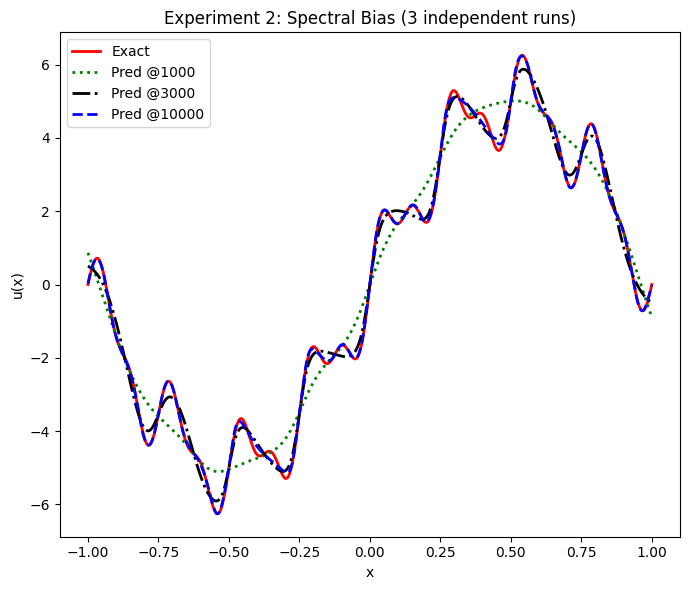

In [22]:
# 학습 결과
styles = {1000:"g:", 3000:"k-.", 10000:"b--"}
plt.figure(figsize=(7,6))
plt.plot(x_test, y_test, 'r', lw=2, label='Exact')
for s in sorted(preds_spec.keys()):
    plt.plot(x_test, preds_spec[s], styles.get(s, 'b--'), lw=2, label=f'Pred @{s}')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Experiment 2: Spectral Bias (3 independent runs)')
plt.legend(loc='upper left'); plt.tight_layout(); plt.show()

## 실험 3 Fourier Feature Embedding

##### FFE를 적용시켜 1D Regression 수렴 속도를 상승함을 확인
##### 다른 예제와 다르게 1000epoch만에 수렴함을 확인

In [23]:
m = 10
scale = 3.0
num_ff_steps = 1000
lr_ff = 1.0e-3

### Define Model

In [24]:
torch.manual_seed(42)
B = (scale * torch.randn(1, m)).cpu().numpy().astype(np.float32)    # [1, m]

xtr = x_train.reshape(-1,1).astype(np.float32)            # (N,1)
xte = x_test.reshape(-1,1).astype(np.float32)

proj_tr = 2*np.pi * (xtr @ B)   # (N, m)
proj_te = 2*np.pi * (xte @ B)

invar_train_ff = {}
invar_test_ff  = {}
for i in range(m):
    invar_train_ff[f"ff_sin_{i}"] = np.sin(proj_tr[:, i:i+1])
    invar_test_ff[f"ff_sin_{i}"]  = np.sin(proj_te[:, i:i+1])
for i in range(m):
    invar_train_ff[f"ff_cos_{i}"] = np.cos(proj_tr[:, i:i+1])
    invar_test_ff[f"ff_cos_{i}"]  = np.cos(proj_te[:, i:i+1])

In [25]:
# FFE Network: 입력 Key = ff_sin_i + ff_cos_i
ffe_keys = [Key(f"ff_sin_{i}") for i in range(m)] + [Key(f"ff_cos_{i}") for i in range(m)]
def _new_ffe_net():
    return FullyConnectedArch(
        input_keys=ffe_keys,
        output_keys=[Key("u")],
        nr_layers=2,
        layer_size=50,
        activation_fn=Activation.TANH,
    )

random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

In [26]:
with open_dict(cfg):
    cfg.training.max_steps = num_ff_steps
    cfg.optimizer.lr = lr_ff
    cfg.network_dir = os.path.join("outputs", "fourier")
    os.makedirs(cfg.network_dir, exist_ok=True)
    np.save(os.path.join(cfg.network_dir, "B.npy"), B)

In [27]:
net = _new_ffe_net()

### Nodes, Constraint, Domain

In [28]:
nodes = [net.make_node(name="u_network")]

data_con = PointwiseConstraint.from_numpy(
    nodes=nodes, invar=invar_train_ff, outvar=outvar_train, batch_size=batch_size_data
)
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

In [29]:
slv = Solver(cfg, domain)
slv.solve()

[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/fourier
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  7.170e-03s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/fourier
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  1.467e+03
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  3.976e-01, time/iteration:  5.119e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  5.412e-02, time/iteration:  4.922e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  2.575e-02, time/iteration:  5.132e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  2.222e-02, time/iteration:  4.969e+00 ms
[INFO] physicsnemo.sym.trainer: [st

### 학습 결과

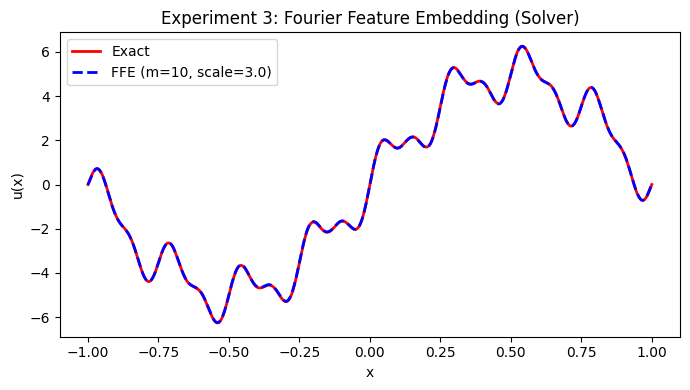

In [30]:
# 체크포인트 로드 & 예측
net_star = _new_ffe_net()
ckpt_path = os.path.join(cfg.network_dir, "u_network.0.pth")
net_star.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
net_star.eval()

with torch.no_grad():
    invar_test_ff_torch = {k: torch.from_numpy(v).float() for k, v in invar_test_ff.items()}
    pred_ff = net_star(invar_test_ff_torch)["u"].cpu().numpy().reshape(-1)

# 플롯
plt.figure(figsize=(7,4))
plt.plot(x_test, y_test, 'r', lw=2, label='Exact')
plt.plot(x_test, pred_ff, 'b--', lw=2, label=f'FFE (m={m}, scale={scale})')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Experiment 3: Fourier Feature Embedding (Solver)')
plt.legend(); plt.tight_layout(); plt.show()

# 2D Function Regression Problem
다음 2차원 함수에 대해 Regression 문제를 해결합니다.
$$ u(x_1,x_2) = x_1 x_2 \sqrt{|\cos(\pi x_1) \cos(\pi x_2)}, \qquad (x_1,x_2) \in [50,54]^2. $$

Given a set of $N$ training data $\{X^i,u^i\}_{i=1}^N$, where $X^i=(x_1^i,x_2^i)$ and $u^i=u(x_1^i,x_2^i)$, train a neural network to approximate $u(x_1,x_2)$.


이 예제를 통해 모델 학습에서 사용하는 정규화를 이해합니다.

정규화를 통해 성능이 개선됨을 확인할 수 있습니다.

In [31]:
#%% Regression 2D — 데이터 샘플링(GeometryDatapipe) + 테스트 그리드 준비
import numpy as np, torch

### Define Problem

In [32]:
import math
def target_function_np(x1, x2):
    return x1 * x2 * np.sqrt(np.abs(np.cos(np.pi * x1) * np.cos(np.pi * x2)))
def target_function_torch(x1, x2):
    return x1 * x2 * torch.sqrt(torch.abs(torch.cos(math.pi * x1) * torch.cos(math.pi * x2)))

### Load Configuration

In [33]:
!ls

config_1D_Regression.yaml  config_2D_Regression.yaml  config_BVP.yaml  outputs


In [34]:
%cp config_2D_Regression.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_2D_Regression"
cfg = compose(config_name=config_name)

### Define Geometry, Dataset, Model

In [35]:
from physicsnemo.sym.geometry.primitives_2d import Rectangle
from physicsnemo.sym.geometry.geometry_dataloader import GeometryDatapipe

In [36]:
# 2D 도메인에서 PN으로 N개 샘플
N = int(getattr(getattr(cfg, "data", {}), "N", 4000))
x_min = float(getattr(getattr(cfg, "data", {}), "x_min", 50.0))
x_max = float(getattr(getattr(cfg, "data", {}), "x_max", 54.0))
grid_n = int(getattr(getattr(cfg, "data", {}), "grid_n", 100))

rec = Rectangle((x_min, x_min), (x_max, x_max))
train_dp = GeometryDatapipe(
    geom_objects=[rec],
    batch_size=1,
    num_points=N,
    sample_type="volume",
    device="cpu",
    num_workers=1,
    requested_vars=["x", "y"],
)

batch = next(iter(train_dp))[0]
x1_t = batch["x"].reshape(-1, 1)   # torch (N,1)
x2_t = batch["y"].reshape(-1, 1)   # torch (N,1)
X_t  = torch.cat([x1_t, x2_t], dim=1)              # torch (N,2)

y_t  = target_function_torch(x1_t, x2_t)           # torch (N,1)

/usr/local/lib/python3.12/dist-packages/nvidia/dali/plugin/base_iterator.py:208: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()


In [37]:
# 테스트 격자
x1_test = np.linspace(x_min, x_max, grid_n, dtype=np.float32)
x2_test = np.linspace(x_min, x_max, grid_n, dtype=np.float32)
X1g, X2g = np.meshgrid(x1_test, x2_test, indexing="xy")
X_test = np.stack([X1g.ravel(), X2g.ravel()], axis=1).astype(np.float32)
Y_exact = target_function_np(X1g, X2g)

# from_numpy용 dict (A run)
invar_train_2d = {"x": x1_t.cpu().numpy(), "y": x2_t.cpu().numpy()}
outvar_train_2d = {"u": y_t.cpu().numpy()}
invar_test_2d = {"x": X_test[:, 0:1], "y": X_test[:, 1:2]}

# 배치=전량 (안전 클램프)
dataset_size = invar_train_2d["x"].shape[0]
batch_size_data = dataset_size
print(f"[2D] dataset_size={dataset_size}, batch_size_data={batch_size_data}")

[2D] dataset_size=4000, batch_size_data=4000


In [38]:
#%% Regression 2D — 공통: 네트워크/노드 정의
from physicsnemo.sym.key import Key
from physicsnemo.sym.models.activation import Activation
from physicsnemo.sym.models.fully_connected import FullyConnectedArch

def _new_reg2d_net():
    # ★모델 구조 확정 필요: (질문) 2×50 Tanh 로 1D와 통일? 아니면 원본 2D대로 3×50?
    return FullyConnectedArch(
        input_keys=[Key("x"), Key("y")],
        output_keys=[Key("u")],
        nr_layers=3,          # ← (가이드: 3)  ← 원하시면 2 로 바꿔 1D와 통일 가능
        layer_size=50,
        activation_fn=Activation.TANH,
    )

## 실험 1 Baseline

In [39]:
#%% Regression 2D — 실험 A: 무정규화 (라벨 감독 + Solver)
from physicsnemo.sym.domain.constraint import PointwiseConstraint
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.solver import Solver
from omegaconf import open_dict
import os, torch, matplotlib.pyplot as plt

# cfg 안정화 (초기엔 가속 off, 스케줄러 무력화는 conf에 반영)
with open_dict(cfg):
    cfg.network_dir = os.path.join("outputs", "reg2d_A")
    cfg.training.max_steps = int(getattr(getattr(cfg, "train", {}), "epochs_A", 10000))
    cfg.jit = False
    cfg.cuda_graphs = False
    cfg.amp.enabled = False
    cfg.training.print_stats_freq = 100

In [40]:
net = _new_reg2d_net()

### Define Node, Constraint, Domain

In [41]:
nodes = [net.make_node("u_network")]
data_con = PointwiseConstraint.from_numpy(nodes=nodes, invar=invar_train_2d,
                                          outvar=outvar_train_2d, batch_size=batch_size_data)
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

In [42]:
slv = Solver(cfg, domain)
slv.solve()

[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_A
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  1.453e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_A
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  1.168e+10
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  1.149e+10, time/iteration:  8.980e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  1.143e+10, time/iteration:  7.827e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  1.136e+10, time/iteration:  7.798e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  1.130e+10, time/iteration:  7.959e+00 ms
[INFO] physicsnemo.sym.trainer: [st

### 학습 결과

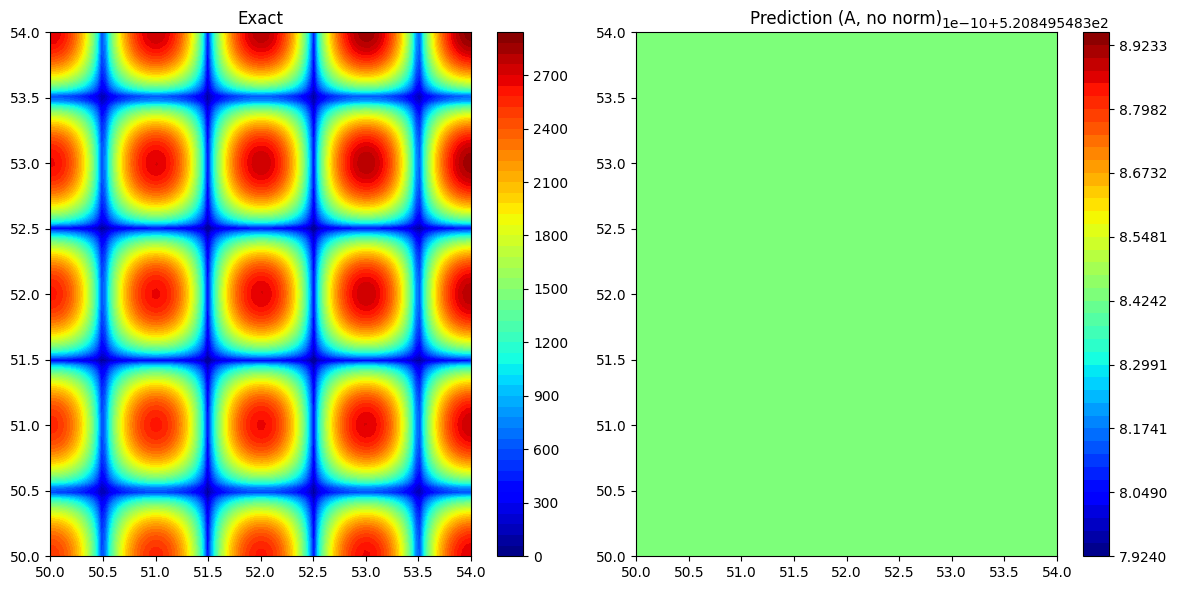

In [43]:
# 체크포인트 로드→테스트 예측
net_A = _new_reg2d_net()
ckpt_A = os.path.join(cfg.network_dir, "u_network.0.pth")
net_A.load_state_dict(torch.load(ckpt_A, map_location="cpu"))
net_A.eval()
with torch.no_grad():
    X1 = torch.from_numpy(invar_test_2d["x"]).float()
    X2 = torch.from_numpy(invar_test_2d["y"]).float()
    Yp_A = net_A({"x": X1, "y": X2})["u"].cpu().numpy().reshape(X1g.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.contourf(X1g, X2g, Y_exact, levels=50, cmap="jet"); plt.colorbar(); plt.title("Exact")
plt.subplot(1,2,2); plt.contourf(X1g, X2g, Yp_A,   levels=50, cmap="jet"); plt.colorbar(); plt.title("Prediction (A, no norm)")
plt.tight_layout(); plt.show()

## 실험 2. normalization (정규화)

In [44]:
#%% Regression 2D — 실험 B: 입력/출력 정규화
import numpy as np

X_np = X_t.cpu().numpy()                   # (N,2)
y_np = y_t.cpu().numpy()                   # (N,1)
X_mean = X_np.mean(axis=0, keepdims=True)
X_std  = X_np.std(axis=0, keepdims=True) + 1e-12
y_mean = y_np.mean(keepdims=True)
y_std  = y_np.std(keepdims=True) + 1e-12

# 정규화
invar_train_2d_B = {
    "x": ((X_np[:, 0:1] - X_mean[:, 0:1]) / X_std[:, 0:1]),
    "y": ((X_np[:, 1:2] - X_mean[:, 1:2]) / X_std[:, 1:2]),
}
outvar_train_2d_B = {
    "u": ((y_np - y_mean) / y_std),
}

with open_dict(cfg):
    cfg.network_dir = os.path.join("outputs", "reg2d_B")
    cfg.training.max_steps = int(getattr(getattr(cfg, "train", {}), "epochs_B", 10000))
    cfg.jit = False
    cfg.cuda_graphs = False
    cfg.amp.enabled = False
    cfg.training.print_stats_freq = 100

In [45]:
net = _new_reg2d_net()

### Define node, constraint, Domain

In [46]:
nodes = [net.make_node("u_network")]
data_con = PointwiseConstraint.from_numpy(nodes=nodes, invar=invar_train_2d_B,
                                          outvar=outvar_train_2d_B, batch_size=batch_size_data)
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

In [47]:
slv = Solver(cfg, domain)
slv.solve()

[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_B
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  1.600e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_B
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  6.195e+03
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  3.829e+03, time/iteration:  8.350e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  3.239e+03, time/iteration:  8.093e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  2.785e+03, time/iteration:  7.929e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  2.553e+03, time/iteration:  8.144e+00 ms
[INFO] physicsnemo.sym.trainer: [st

### 학습 결과 (정규화)

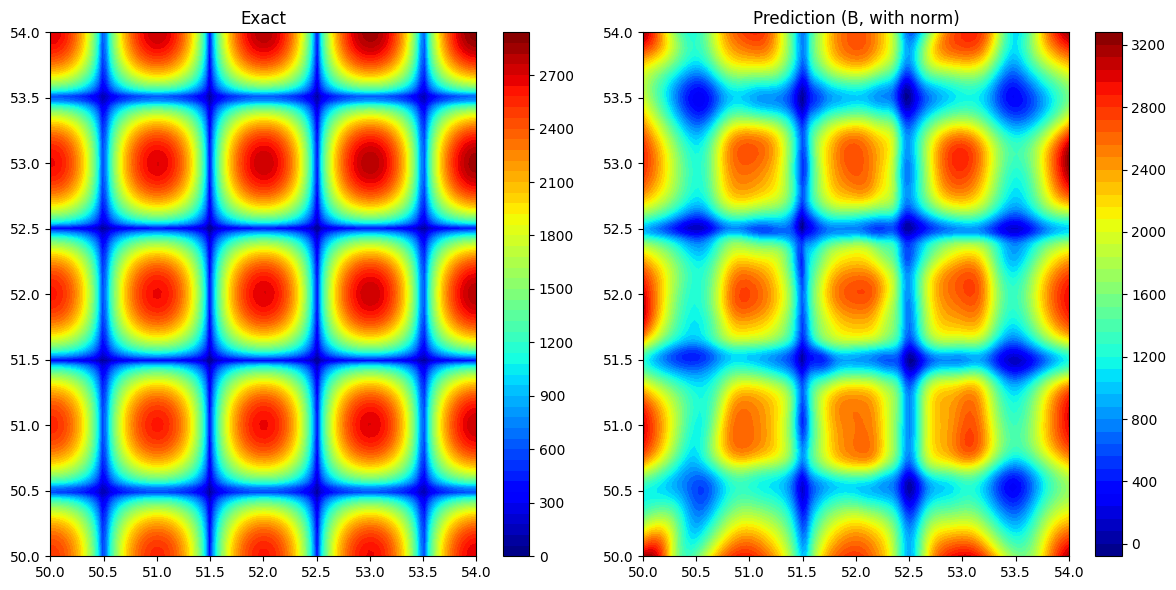

In [48]:
# 테스트 정규화→예측→역정규화
net_B = _new_reg2d_net()
ckpt_B = os.path.join(cfg.network_dir, "u_network.0.pth")
net_B.load_state_dict(torch.load(ckpt_B, map_location="cpu"))
net_B.eval()
with torch.no_grad():
    X1n = (invar_test_2d["x"] - X_mean[:, 0:1]) / X_std[:, 0:1]
    X2n = (invar_test_2d["y"] - X_mean[:, 1:2]) / X_std[:, 1:2]
    X1n_t = torch.from_numpy(X1n).float()
    X2n_t = torch.from_numpy(X2n).float()
    Yp_B_n = net_B({"x": X1n_t, "y": X2n_t})["u"].cpu().numpy().reshape(-1,1)
    Yp_B = (Yp_B_n * y_std + y_mean).reshape(X1g.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.contourf(X1g, X2g, Y_exact, levels=50, cmap="jet"); plt.colorbar(); plt.title("Exact")
plt.subplot(1,2,2); plt.contourf(X1g, X2g, Yp_B,   levels=50, cmap="jet"); plt.colorbar(); plt.title("Prediction (B, with norm)")
plt.tight_layout(); plt.show()

# Poisson problem

다음 Poisson 문제를 모델 학습을 통해 해결합니다.
$$ -u''(x) = f(x), \qquad x\in[-1,1], \qquad u(-1)=u(1)=0 $$
where $ f(x) = 5\pi^2 \sin(\pi x) + 64\pi^2\sin(8\pi x) + 128\pi^2\sin(16\pi x).$
이 문제의 exact solution은
$$u(x) = 5\sin(\pi x) +\sin(8\pi x)+0.5\sin(16\pi x).$$
입니다.

Loss function은 Residual Loss와 Boundary Loss 두 항으로 구성됩니다.

$$
L(\theta) = w_R \underbrace{\frac{1}{N_R} \sum_{i=1}^{N_R} \left| \hat{u}''(x_i)+f(x_i) \right|^2 }_{\text{residual loss}}
+ w_B \underbrace{\frac{1}{N_B} \sum_{i=1}^{N_B} \left| \hat{u}(x^{BC}_i) \right|^2}_{\text{boundary loss}}
$$
        
여기서 $w_R$ , $w_B$ 는 각 손실의 가중치 입니다.

이 예제를 통해 FFE와 적절한 $w_B$ 선택의 중요성을 확인합니다.

In [49]:
import os, re, glob, time
import math, numpy as np, torch
import matplotlib.pyplot as plt
from sympy import Symbol, Function, sin, pi, Eq

from physicsnemo.sym.eq.pde import PDE
from physicsnemo.sym.key import Key
from physicsnemo.sym.models.activation import Activation
from physicsnemo.sym.models.fully_connected import FullyConnectedArch
from physicsnemo.models.layers import FourierLayer
from physicsnemo.sym.models.fully_connected import FullyConnectedArchCore
from physicsnemo.sym.models.arch import Arch
from physicsnemo.sym.geometry.primitives_1d import Line1D
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.domain.constraint import PointwiseInteriorConstraint, PointwiseBoundaryConstraint
from physicsnemo.sym.solver import Solver

In [50]:
from omegaconf import OmegaConf, open_dict
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

In [51]:
!ls

config_1D_Regression.yaml  config_2D_Regression.yaml  config_BVP.yaml  outputs


In [52]:
%cp config_BVP.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_BVP"
cfg = compose(config_name=config_name)

In [53]:
class Poisson1D(PDE):
    name = 'Poisson1D'
    def __init__(self):
        x = Symbol('x')
        input_variables = {'x': x}
        u = Function('u')(*input_variables)
        f = (pi**2) * (5*sin(pi*x) + 64*sin(8*pi*x) + 128*sin(16*pi*x))
        self.equations = {'poisson': u.diff(x, 2) + f}

In [54]:
# -------------------------------
# FourierNet (FFE)
# -------------------------------
class FourierNetArchLocal(Arch):
    """PhysicsNeMo 구성요소로 만든 Fourier feature 네트워크.
    - FourierLayer("gaussian", std, m) 사용
    - use_2pi=True: 구버전 RFF의 2π 스케일을 반영 (std_eff = 2π*std)
    - freeze_fourier=True: 구버전처럼 고정 RFF 사용(학습 불가)
    - include_raw_x: 원본 x를 특징에 붙일지 여부
    """
    def __init__(
        self,
        input_keys,
        output_keys,
        nr_layers=3,
        layer_size=100,
        m=10,
        std=3.0,
        include_raw_x=False,
        activation_fn=Activation.SILU,
        weight_norm=False,
        adaptive_activations=False,
        use_2pi=True,
        freeze_fourier=True
    ):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.include_raw_x = include_raw_x

        in_features_raw = sum(self.input_key_dict.values())
        out_features = sum(self.output_key_dict.values())

        # 2π 스케일 반영
        eff_std = float(std) * (2.0 * math.pi) if use_2pi else float(std)
        self.fourier = FourierLayer(
            in_features=in_features_raw,
            frequencies=("gaussian", eff_std, int(m))
        )
        if freeze_fourier:
            for p in self.fourier.parameters():
                p.requires_grad_(False)

        in_features = self.fourier.out_features() + (in_features_raw if include_raw_x else 0)
        self.fc = FullyConnectedArchCore(
            in_features=in_features,
            layer_size=layer_size,
            out_features=out_features,
            nr_layers=nr_layers,
            skip_connections=False,
            activation_fn=activation_fn,
            adaptive_activations=adaptive_activations,
            weight_norm=weight_norm,
        )

    def forward(self, in_vars):
        x = in_vars['x']                  # [N, 1]
        feats = self.fourier(x)           # [N, 2m] (sin, cos)
        if self.include_raw_x:
            feats = torch.cat([x, feats], dim=-1)
        u = self.fc(feats)
        return {'u': u}

In [55]:
def build_network_from_cfg(cfg):
    if bool(cfg.custom.use_fourier):
        ff = cfg.custom.fourier
        return FourierNetArchLocal(
            input_keys=[Key('x')], output_keys=[Key('u')],
            nr_layers=cfg.arch.fully_connected.nr_layers,
            layer_size=cfg.arch.fully_connected.layer_size,
            m=int(ff.m), std=float(ff.std), include_raw_x=bool(ff.include_raw_x),
            activation_fn=Activation.SILU,
            use_2pi=True,
            freeze_fourier=True
        )
    else:
        return FullyConnectedArch(
            input_keys=[Key('x')], output_keys=[Key('u')],
            nr_layers=cfg.arch.fully_connected.nr_layers,
            layer_size=cfg.arch.fully_connected.layer_size,
            activation_fn=Activation.SILU,
        )

# -------------------------------
# Constraints (lambda_weighting으로 w_B 적용)
# -------------------------------
from sympy import Eq, Symbol

def make_domain(cfg, nodes):
    geo = Line1D(float(cfg.data.x_min), float(cfg.data.x_max))

    interior = PointwiseInteriorConstraint(
        nodes=nodes, geometry=geo, outvar={'poisson': 0.0},
        batch_size=int(cfg.batch_size.Interior), batch_per_epoch=1,
        lambda_weighting={'poisson': 1.0},  # w_R=1
    )

    BC_left  = PointwiseBoundaryConstraint(
        nodes=nodes, geometry=geo, outvar={'u': 0.0},
        criteria=Eq(Symbol('x'), float(cfg.data.x_min)),  # x == -1
        batch_size=1, batch_per_epoch=1,
        lambda_weighting={'u': float(cfg.loss.weights.BC)},  # ★ 여기서 w_B 적용
    )
    BC_right = PointwiseBoundaryConstraint(
        nodes=nodes, geometry=geo, outvar={'u': 0.0},
        criteria=Eq(Symbol('x'), float(cfg.data.x_max)),  # x == +1
        batch_size=1, batch_per_epoch=1,
        lambda_weighting={'u': float(cfg.loss.weights.BC)},  # ★ 여기서 w_B 적용
    )

    domain = Domain()
    domain.add_constraint(interior, 'interior')
    domain.add_constraint(BC_left, 'BC_left')
    domain.add_constraint(BC_right, 'BC_right')
    return domain

# -------------------------------
# [A-2] 체크포인트 선택 함수 (final > max step > 0)
# -------------------------------
def pick_ckpt(network_dir: str):
    final = os.path.join(network_dir, "u_network.final.pth")
    if os.path.exists(final):
        return final
    best, best_step = None, -1
    for f in glob.glob(os.path.join(network_dir, "u_network.*.pth")):
        m = re.match(r"u_network\.(\d+)\.pth$", os.path.basename(f))
        if m:
            s = int(m.group(1))
            if s > best_step:
                best, best_step = f, s
    if best is not None:
        return best
    f0 = os.path.join(network_dir, "u_network.0.pth")
    return f0 if os.path.exists(f0) else None

# -------------------------------
# Train one (Solver) — [A-1] 최종 가중치 강제 저장
# -------------------------------
def run_one(cfg):
    torch.manual_seed(42)
    np.random.seed(42)
    pde = Poisson1D()
    u_net = build_network_from_cfg(cfg)
    nodes = pde.make_nodes() + [u_net.make_node('u_network')]
    domain = make_domain(cfg, nodes)
    solver = Solver(cfg, domain)

    # 1D VTK 기록 제거(옵션)
    DISABLE_RECORD = True
    if DISABLE_RECORD:
        solver.record_constraints = lambda: None
        solver.record_validators  = lambda step: None
        solver.record_inferences  = lambda step: None

    solver.solve()

    # ★ 최종 가중치 강제 저장 (프레임워크 내부 저장과 무관하게 확보)
    os.makedirs(cfg.network_dir, exist_ok=True)
    final_ckpt = os.path.join(cfg.network_dir, "u_network.final.pth")
    torch.save(u_net.state_dict(), final_ckpt)
    print(f"[FINAL SAVE] saved final weights to {final_ckpt}")
    return cfg

In [56]:
# -------------------------------
# Runs
# -------------------------------
tags = [
    ('FFE_wB100',  True,  100.0),
    ('FFE_wB1',    True,    1.0),
    ('noFFE_wB100', False, 100.0),
    ('noFFE_wB1',   False,   1.0),
]

ckpt_paths = {}
for tag, use_ff, wB in tags:
    print(f"\n=== Run: {tag} ===")
    cfg_local = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    with open_dict(cfg_local):
        cfg_local.custom.use_fourier = bool(use_ff)
        cfg_local.loss.weights.BC = float(wB)
        # [A-3] 절대경로로 고정
        cfg_local.network_dir = os.path.abspath(
            os.path.join(os.getcwd(), 'outputs', f"poisson1d_{tag}_{int(time.time())}")
        )
        # [B] FuncArch 비활성화(경고 제거/일관성 ↑)
        if 'graph' not in cfg_local:
            cfg_local.graph = OmegaConf.create({})
        cfg_local.graph.func_arch = False

    print(f"[{tag}] using w_B = {cfg_local.loss.weights.BC} | func_arch={cfg_local.graph.func_arch}")
    print(f"[{tag}] network_dir = {cfg_local.network_dir}")

    run_one(cfg_local)

    # [A-2] 안전한 체크포인트 선택
    ckpt = pick_ckpt(cfg_local.network_dir)
    ckpt_paths[tag] = ckpt
    print('[CKPT]', tag, '→', ckpt)

print('\n[Done] All runs finished.')

[WARNING] physicsnemo.sym.graph: Arch <class '__main__.FourierNetArchLocal'> currently does not support FuncArch
[WARNING] physicsnemo.sym.graph: Arch <class '__main__.FourierNetArchLocal'> currently does not support FuncArch
[WARNING] physicsnemo.sym.graph: Arch <class '__main__.FourierNetArchLocal'> currently does not support FuncArch
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB100_1762791994
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/eq/derivatives.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  4.053e-06s
[INFO] physicsnemo.sym.trainer:


=== Run: FFE_wB100 ===
[FFE_wB100] using w_B = 100.0 | func_arch=False
[FFE_wB100] network_dir = /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB100_1762791994


[INFO] physicsnemo.sym.trainer: [step:        200] loss:  4.853e+02, time/iteration:  1.323e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  8.783e+01, time/iteration:  1.475e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        600] loss:  6.411e+01, time/iteration:  1.413e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        800] loss:  5.345e+01, time/iteration:  1.325e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1000] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB100_1762791994
[INFO] physicsnemo.sym.trainer: [step:       1000] loss:  4.513e+01, time/iteration:  1.300e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1200] loss:  9.477e+02, time/iteration:  1.295e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1400] loss:  3.437e+01, time/iteration:  1.572e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1600] loss:  5.585e+01, time/iteration:  1.316e+01 ms
[INFO] physicsnemo.sym.trainer: [step:    

[FINAL SAVE] saved final weights to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB100_1762791994/u_network.final.pth
[CKPT] FFE_wB100 → /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB100_1762791994/u_network.final.pth

=== Run: FFE_wB1 ===
[FFE_wB1] using w_B = 1.0 | func_arch=False
[FFE_wB1] network_dir = /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB1_1762792035


[INFO] physicsnemo.sym.trainer: [step:        200] loss:  4.828e+02, time/iteration:  1.459e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  8.551e+01, time/iteration:  1.288e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        600] loss:  6.175e+01, time/iteration:  1.301e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        800] loss:  5.110e+01, time/iteration:  1.305e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1000] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB1_1762792035
[INFO] physicsnemo.sym.trainer: [step:       1000] loss:  1.193e+04, time/iteration:  1.578e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1200] loss:  3.664e+01, time/iteration:  1.306e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1400] loss:  3.224e+01, time/iteration:  1.325e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1600] loss:  3.223e+01, time/iteration:  1.305e+01 ms
[INFO] physicsnemo.sym.trainer: [step:      

[FINAL SAVE] saved final weights to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB1_1762792035/u_network.final.pth
[CKPT] FFE_wB1 → /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB1_1762792035/u_network.final.pth

=== Run: noFFE_wB100 ===
[noFFE_wB100] using w_B = 100.0 | func_arch=False
[noFFE_wB100] network_dir = /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB100_1762792077


[INFO] physicsnemo.sym.trainer: [step:        200] loss:  9.897e+05, time/iteration:  2.190e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  3.862e+05, time/iteration:  2.467e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        600] loss:  1.199e+05, time/iteration:  2.169e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        800] loss:  5.560e+03, time/iteration:  2.302e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1000] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB100_1762792077
[INFO] physicsnemo.sym.trainer: [step:       1000] loss:  2.494e+02, time/iteration:  2.356e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1200] loss:  2.409e+02, time/iteration:  2.178e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1400] loss:  5.211e+01, time/iteration:  2.456e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1600] loss:  2.810e+01, time/iteration:  2.176e+01 ms
[INFO] physicsnemo.sym.trainer: [step:  

[FINAL SAVE] saved final weights to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB100_1762792077/u_network.final.pth
[CKPT] noFFE_wB100 → /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB100_1762792077/u_network.final.pth

=== Run: noFFE_wB1 ===
[noFFE_wB1] using w_B = 1.0 | func_arch=False
[noFFE_wB1] network_dir = /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB1_1762792146


[INFO] physicsnemo.sym.trainer: [step:        200] loss:  1.308e+06, time/iteration:  2.198e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  1.262e+05, time/iteration:  2.254e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        600] loss:  5.390e+03, time/iteration:  2.439e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        800] loss:  1.396e+03, time/iteration:  2.172e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1000] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB1_1762792146
[INFO] physicsnemo.sym.trainer: [step:       1000] loss:  7.085e+02, time/iteration:  2.464e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1200] loss:  2.442e+02, time/iteration:  2.172e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1400] loss:  2.515e+03, time/iteration:  2.192e+01 ms
[INFO] physicsnemo.sym.trainer: [step:       1600] loss:  1.723e+02, time/iteration:  2.452e+01 ms
[INFO] physicsnemo.sym.trainer: [step:    

[FINAL SAVE] saved final weights to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB1_1762792146/u_network.final.pth
[CKPT] noFFE_wB1 → /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB1_1762792146/u_network.final.pth

[Done] All runs finished.


[EVAL] FFE_wB100 -> /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB100_1762791994/u_network.final.pth
       missing: [], unexpected: []
[EVAL] FFE_wB1 -> /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_FFE_wB1_1762792035/u_network.final.pth
       missing: [], unexpected: []
[EVAL] noFFE_wB100 -> /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB100_1762792077/u_network.final.pth
       missing: [], unexpected: []
[EVAL] noFFE_wB1 -> /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/poisson1d_noFFE_wB1_1762792146/u_network.final.pth
       missing: [], unexpected: []


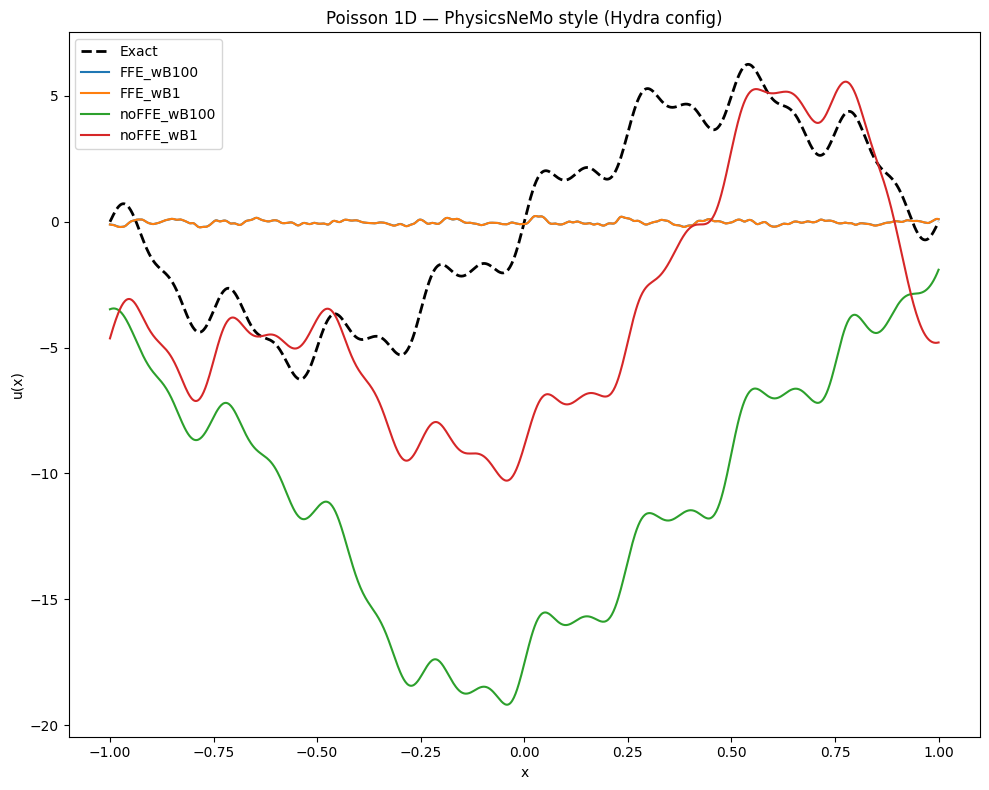

In [57]:
# -------------------------------
# Evaluate & Plot
# -------------------------------
# 테스트 그리드
x_test = np.linspace(float(cfg.data.x_min), float(cfg.data.x_max), int(cfg.data.N_test), dtype=np.float32)
def exact_solution_np(x):
    return 5*np.sin(np.pi*x) + np.sin(8*np.pi*x) + 0.5*np.sin(16*np.pi*x)
u_exact = exact_solution_np(x_test)

def build_eval_net(cfg_local):
    if bool(cfg_local.custom.use_fourier):
        ff = cfg_local.custom.fourier
        return FourierNetArchLocal(
            input_keys=[Key('x')], output_keys=[Key('u')],
            nr_layers=cfg_local.arch.fully_connected.nr_layers,
            layer_size=cfg_local.arch.fully_connected.layer_size,
            m=int(ff.m), std=float(ff.std), include_raw_x=bool(ff.include_raw_x),
            activation_fn=Activation.SILU,
            use_2pi=True,
            freeze_fourier=True
        )
    else:
        return FullyConnectedArch(
            input_keys=[Key('x')], output_keys=[Key('u')],
            nr_layers=cfg_local.arch.fully_connected.nr_layers,
            layer_size=cfg_local.arch.fully_connected.layer_size,
            activation_fn=Activation.SILU,
        )

preds = {}
for tag, use_ff, wB in tags:
    ndir = os.path.dirname(ckpt_paths[tag]) if ckpt_paths.get(tag) else None
    ckpt = ckpt_paths.get(tag) or (pick_ckpt(ndir) if ndir else None)
    if not ckpt:
        print('[Warn] No ckpt for', tag)
        continue

    cfg_eval = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    with open_dict(cfg_eval):
        cfg_eval.custom.use_fourier = bool(use_ff)

    net = build_eval_net(cfg_eval)
    state = torch.load(ckpt, map_location='cpu')
    # 로딩 검증 로그(참고용)
    msg = net.load_state_dict(state, strict=False)
    print(f"[EVAL] {tag} -> {ckpt}")
    print(f"       missing: {msg.missing_keys}, unexpected: {msg.unexpected_keys}")
    net.eval()

    with torch.no_grad():
        xt = torch.from_numpy(x_test.reshape(-1,1)).float()
        yh = net({'x': xt})['u'].cpu().numpy().reshape(-1)
    preds[tag] = yh

plt.figure(figsize=(10,8))
plt.plot(x_test, u_exact, 'k--', linewidth=2.0, label='Exact')
for tag, yhat in preds.items():
    plt.plot(x_test, yhat, label=tag)
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Poisson 1D — PhysicsNeMo style (Hydra config)')
plt.legend(); plt.tight_layout(); plt.show()

# [PDE] Burgers' equation 예제

- 다음과 같은 Burgers' equation에 대해 PINN 학습을 진행합니다.
$$u_t+u u_x -\nu u_{xx}=0, \quad (x,t)\in\Omega$$
$$ u(x,0) = -\sin(\pi x) $$
$$u(-1,t)=u(1,t)=0$$
where $ \Omega = [-1,1]\times[0,1]$.

  Take $\nu = \frac{0.01}{\pi}$.

## Burgers' equation 정의
- **physicsnemo의 PDE 클래스**를 상속하여 burgers' equation을 정의합니다

In [96]:
from physicsnemo.sym.eq.pde import PDE
from numpy import pi
from sympy import Symbol, Eq, Abs, Number, Function

In [97]:
class CustomPDE(PDE):
    name = "BurgersEquation1D"
    def __init__(self, alpha = 0.01/pi):
        ## coordinates
        x = Symbol("x")
        ## time
        t = Symbol("t")

        ## Make input variables
        input_variables = {"t":t, "x":x}

        ## Make u function
        u = Function("u")(*input_variables)

        ## Coefficient alpha
        if type(alpha) is str:
            alpha = Function(alpha)(*input_variables)
        elif type(alpha) in [float, int]:
            alpha = Number(alpha)

        ## Set equations
        self.equations = {}
        self.equations["Burgers"] = (
            u.diff(t) + u*u.diff(x) - alpha*u.diff(x,2)
        ) ## "custom_pde" key name will be used in constraints

In [98]:
Burgers = CustomPDE(alpha = 0.01/pi)

### Load Configuration

In [99]:
%cd /content/physicsnemo_tutorial/PINNs/Burgers/conf/
%mkdir /tmp/conf
%cp config_Burgers.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_Burgers"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/Burgers/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


In [100]:
from omegaconf import OmegaConf, open_dict
with open_dict(cfg):
    cfg.network_dir = "outputs_Burgers"
    cfg.training.max_steps = 5000
print(OmegaConf.to_yaml(cfg))

training:
  max_steps: 5000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  grad_clip_max_norm: 0.5
  monitor_grad_clip: true
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
amp:
  enabled: false
  mode: per_order_scaler
  dtype: float16
  autocast_activation: false
  autocast_firstlayer: false
  default_max_scale_log2: 0
  custom_max_scales_log2: {}
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs_Burgers
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: 'off'
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: 

## 학습 모델 정의
- physicsnemo에는 다양한 모델 클래스가 존재합니다.

- 이번 학습에서 사용할 fully connected MLP 모델은 다음과 같이 사용할 수 있습니다

In [101]:
from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra import to_absolute_path, instantiate_arch
from physicsnemo.sym.models.activation import Activation
from physicsnemo.sym.models.fully_connected import FullyConnectedArch

In [102]:
u_net = FullyConnectedArch(
    input_keys=[Key("t"), Key("x")],
    output_keys=[Key("u")],
    nr_layers=4,
    layer_size=64,
    activation_fn=Activation.TANH,
)

- physicsnemo의 PDE 클래스의 기능인 **make_nodes()** 를 통해
- PDE와 Network를 하나로 묶어줍니다.

In [103]:
nodes = Burgers.make_nodes() + [u_net.make_node(name="u_network")]

## 학습 도메인 설정

- **physicsnemo의 도메인 설정 라이브러리인 geometry**를 활용하여 정의합니다.

- 1D, 2D 등 다양한 domain에 대해 정의할 수 있습니다.

- 1D 상에서의 학습을 위해 Line1D를 활용합니다.

In [104]:
from physicsnemo.sym.geometry.primitives_1d import Line1D

In [105]:
t, x = Symbol("t"), Symbol("x")

geo = Line1D(-1,1)
time_range = {t:(0,1)}

## 학습 제약조건 설정
- **physicsnemo의 제약조건 설정 라이브러리인 constraint**를 활용하여 제약조건을 정의합니다.

In [106]:
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from sympy import sin

### Domain 제약조건 등록

- 빈 domain을 생성합니다.

In [107]:
domain = Domain()

- 제약조건을 설정합니다.
- 앞서 정의한 다음 항목들을 제약조건에 등록합니다.
  - nodes (PDE, Network)
  - domain

In [108]:
## Initial Condition
IC = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = geo,
    outvar = {"u": -sin(pi*x)},
    batch_size = 300, ## What is the meaning of batch_size and cfg?
    parameterization={t:0.0},
    batch_per_epoch=1,
)

## Boundary Condition
BC = PointwiseBoundaryConstraint(
    nodes = nodes,
    geometry= geo,
    outvar={"u":0},
    batch_size = 700,
    parameterization=time_range,
    batch_per_epoch=1,
)

## Interior
interior = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = geo,
    outvar = {"Burgers":0},
    batch_size = 6000,
    parameterization=time_range,
    batch_per_epoch=1,
)

[INFO] physicsnemo.sym.graph: Arch Node: u_network has been converted to a FuncArch node.
Arch Node: u_network has been converted to a FuncArch node.


- domain에 제약조건을 등록 합니다.

In [109]:
domain.add_constraint(IC,"IC")
domain.add_constraint(BC,"BC")
domain.add_constraint(interior, "interior")

### Ground Truth

In [110]:
import numpy as np
import scipy.io
%cd /content

data = scipy.io.loadmat('/content/physicsnemo_tutorial/PINNs/Burgers/data/burgers.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.transpose(np.real(data['usol']))
X, T = np.meshgrid(x,t)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_star = Exact.flatten()[:,None]

/content


### 모델 학습 시작

- **physicsnemo solver**를 활용하여 간단하게 학습을 진행할 수 있습니다

In [111]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(name)s: %(message)s', force=True)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
logger.addHandler(stream_handler)

### Loss graph PostProcessing Code - Train Logger에 부착

In [ ]:
# ===========================================
# 6) (선택) 손실 CSV/NPZ 로거
#    - physicsnemo.sym.trainer 로그 파싱 → CSV/NPZ 저장
# ===========================================
class TrainerLossLogger(logging.Handler):
    _pat = re.compile(
        r"\[step:\s*(\d+)\]\s+loss:\s+([0-9eE\+\-\.]+)(?:,\s*time/iteration:\s*([0-9eE\+\-\.]+)\s*ms)?"
    )
    def __init__(self, out_dir, csv_name="loss_log.csv", npz_name="loss_history.npz"):
        super().__init__(level=logging.INFO)
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.csv_path = os.path.join(out_dir, csv_name)
        self.npz_path = os.path.join(out_dir, npz_name)
        self.steps, self.losses, self.times = [], [], []
        self._last_step = None
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["step", "loss", "time_ms"])

    def emit(self, record):
        m = self._pat.search(record.getMessage())
        if not m:
            return
        step = int(m.group(1))
        loss = float(m.group(2))
        t_ms = float(m.group(3)) if m.group(3) is not None else ""
        if self._last_step == step:
            return
        self._last_step = step
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, loss, t_ms])
        self.steps.append(step)
        self.losses.append(loss)
        self.times.append(np.nan if t_ms == "" else float(t_ms))

    def save_npz(self):
        np.savez(self.npz_path,
                 step=np.array(self.steps, dtype=np.int64),
                 loss=np.array(self.losses, dtype=np.float64),
                 time_ms=np.array(self.times, dtype=np.float64))
        return self.npz_path, self.csv_path

trainer_logger = logging.getLogger("physicsnemo.sym.trainer")
loss_logger = TrainerLossLogger(out_dir=cfg.network_dir)
trainer_logger.addHandler(loss_logger)

- solver에 domain을 전달합니다.
- **domain에는 제약조건, nodes(PDE-Network), domain geo (1D)와 같은 정보가 들어가 있습니다.**
- cfg에는 모델 학습 하이퍼파라미터 설정 값들이 들어가 있습니다.

In [112]:
slv = Solver(cfg, domain)
## Start solver
slv.solve()

[WARNING] physicsnemo.sym.trainer: Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/outputs_Burgers
attempting to restore from: /content/outputs_Burgers
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  4.248e-02s
[step:          0] record constraint batch 

In [ ]:
# --- 4) 학습 후 정리(파일 저장, 핸들러 해제) ---------------------------------
npz_path, csv_path = loss_logger.save_npz()
trainer_logger.removeHandler(loss_logger)
print(f"[saved] {csv_path}\n[saved] {npz_path}")

[saved] outputs_1D_WaveEquation/loss_log.csv
[saved] outputs_1D_WaveEquation/loss_history.npz


### Loss graph

In [ ]:
# --- 손실 그래프 그리기 (CSV 기준) ------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_path)  # 위에서 찍힌 경로 사용
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"])
plt.yscale("log")  # ← 요기!
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss (total)")
plt.grid(True, alpha=0.3)
plt.show()

### 학습 결과

- 추론 모델을 선언합니다.

In [113]:
u_net_star = FullyConnectedArch(
    input_keys=[Key("t"), Key("x")],
    output_keys=[Key("u")],
    nr_layers=4,
    layer_size=64,
    activation_fn=Activation.TANH,
)

- 학습했던 모델을 추론 모델에 덮어씌웁니다.

In [114]:
import torch
u_net_star.load_state_dict(torch.load("outputs/u_network.0.pth"))
u_net_star.cuda()

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=64, bias=True)
      )
      (1-3): 3 x FCLayer(
        (linear): WeightNormLinear(in_features=64, out_features=64, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [115]:
input_ = {'t': torch.Tensor(T).cuda(),
          'x': torch.Tensor(X).cuda()}
output = u_net_star(input_)

- 다음과 같이 plot을 그려 결과를 확인할 수 있습니다.

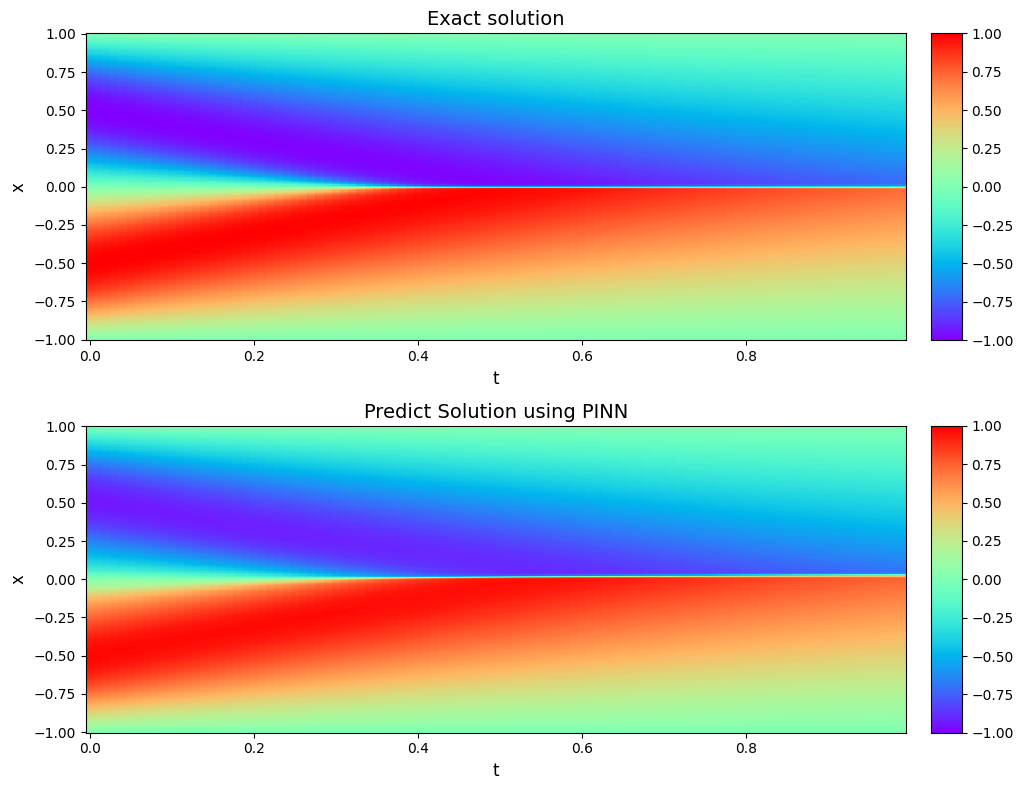

In [116]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
## Plot in 2D
x = X.reshape((100,256))
t = T.reshape((100,256))
u_star = u_star.reshape((100,256))

pred_u = output['u'].cpu().detach().numpy()
pred_u = pred_u.reshape((100,256))
fig = plt.figure(figsize=(11,8))
gs = GridSpec(2, 1)
## Plot Exact Solution
## X_star = (x_i, t_i) i = 1 to 25600 i.e. X_star.shape = (25600,2)
plt.subplot(gs[0,0])
plt.pcolormesh(t, x, u_star,cmap='rainbow')
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Exact solution', fontsize = 14)
cbar = plt.colorbar(pad=0.025, aspect=10)
#cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)

## Plot Predict Solution
plt.subplot(gs[1, 0])
plt.pcolormesh(t, x, pred_u, cmap='rainbow')
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Predict Solution using PINN', fontsize = 14)
cbar = plt.colorbar(pad=0.025, aspect=10)
#cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
plt.tight_layout()
plt.show()

# 1D Wave Equation

## [PDE] Wave equation 예제

- 다음과 같은 1차원 파동 방정식(Wave equation)에 대해 PINN 학습을 진행합니다.

$$
u_{tt} = c^2 u_{xx}, \quad (x,t)\in\Omega
$$

$$
u(0,t) = 0, \quad u(\pi,t) = 0
$$

$$
u(x,0) = \sin(x)
$$

$$
u_t(x,0) = \sin(x)
$$

where $\Omega = [0,\pi]\times[0,T]$.

wave speed : $c = 1$.  
The analytical solution to the above problem is given by

$$
u(x,t) = \sin(x)\,(\sin(t) + \cos(t)).
$$

## 1D Wave Equation 정의
- physicsnemo의 PDE 클래스를 상속하여 정의합니다

In [122]:
from sympy import Symbol, Function, Number, sin, pi
from physicsnemo.sym.eq.pde import PDE

In [123]:
class WaveEquation1D(PDE):
    name = "WaveEquation1D"
    def __init__(self, c=1.0):
        # 좌표/시간 심볼
        x = Symbol("x")
        t = Symbol("t")

        # 입력 변수 dict
        input_variables = {"x": x, "t": t}

        # u(x,t) 상징함수
        u = Function("u")(*input_variables)

        # 파동 속도 c 처리
        if isinstance(c, str):
            c = Function(c)(*input_variables)
        elif isinstance(c, (float, int)):
            c = Number(c)

        # PDE 잔차 정의: wave_equation = u_tt - (c^2 * u_xx) = 0
        self.equations = {
            "wave_equation": u.diff(t, 2) - (c**2 * u.diff(x, 2))
        }

In [ ]:
we = WaveEquation1D(c=1.0)

### Load Configuration

In [145]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, open_dict

In [146]:
%cd /content/physicsnemo_tutorial/PINNs/1D_WaveEquation/conf/
%mkdir /tmp/conf
%cp config_1D_WaveEquation.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_1D_WaveEquation"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/1D_WaveEquation/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


In [147]:
with open_dict(cfg):
    cfg.network_dir = "outputs_1D_WaveEquation"
    cfg.training.max_steps = 1000 # 10000
print(OmegaConf.to_yaml(cfg))

training:
  max_steps: 1000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: ${training.rec_results_freq}
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  grad_clip_max_norm: 0.5
  monitor_grad_clip: true
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
amp:
  enabled: false
  mode: per_order_scaler
  dtype: float16
  autocast_activation: false
  autocast_firstlayer: false
  default_max_scale_log2: 0
  custom_max_scales_log2: {}
graph:
  func_arch: false
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs_1D_WaveEquation
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: 'of

## 학습 모델 정의
- physicsnemo의 fully connected MLP를 사용합니다.

In [148]:
# PhysicsNeMo-Sym
from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra import instantiate_arch
from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.geometry.primitives_1d import Line1D
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
%cd /content

/content


In [149]:
# 네트워크(MLP) 생성
wave_net = instantiate_arch(
    input_keys=[Key("x"), Key("t")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)

- node를 통해 PDE와 Network를 하나로 묶어줍니다.

In [150]:
# PDE 노드 + 네트워크 노드 결합 (학습 그래프 구성)
nodes = we.make_nodes() + [wave_net.make_node(name="u_network")]

## 학습 도메인 및 제약조건 설정
- physicsnemo geometry, domain, constraint를 통해 정의합니다.

In [151]:
# =========================
# Domain 설정
#     공간: x ∈ [0, π], 시간: t ∈ [0, 2π]
# =========================
x_sym, t_sym = Symbol("x"), Symbol("t")
L = float(np.pi)      # 공간 길이 π
geo = Line1D(0.0, L)  # x ∈ [0, π]
time_range = {t_sym: (0.0, 2.0 * L)}  # t ∈ [0, 2π]

In [152]:
# =========================
# Constraints 구성
#     - IC: u(x,0) = sin(x), u_t(x,0) = sin(x)
#     - BC: u(0,t)=0, u(π,t)=0
#     - Interior: wave_equation = 0
# =========================
domain = Domain()

# Initial Condition (t = 0에서 u, u_t 지정)
IC = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": sin(x_sym), "u__t": sin(x_sym)},  # u_t 초기조건은 'u__t' 키
    batch_size=cfg.batch_size.IC,
    lambda_weighting={"u": 1.0, "u__t": 1.0},      # 필요 시 cfg로 조정 가능
    parameterization={t_sym: 0.0},
    batch_per_epoch=1,
)

# Boundary Condition (x 경계에서 Dirichlet 0)
BC = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": 0},
    batch_size=cfg.batch_size.BC,
    parameterization=time_range,   # t를 [0, 2π]에서 샘플
    batch_per_epoch=1,
)

# PDE Interior (공간-시간 내부에서 파동방정식 잔차=0)
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"wave_equation": 0},
    batch_size=cfg.batch_size.interior,
    parameterization=time_range,
    batch_per_epoch=1,
)

[INFO] physicsnemo.sym.graph: Arch Node: u_network has been converted to a FuncArch node.
Arch Node: u_network has been converted to a FuncArch node.
[INFO] physicsnemo.sym.graph: Arch Node: u_network has been converted to a FuncArch node.
Arch Node: u_network has been converted to a FuncArch node.


- domain에 제약조건 등록

In [153]:
domain.add_constraint(IC, "IC")
domain.add_constraint(BC, "BC")
domain.add_constraint(interior, "interior")

### Loss graph PostProcessing Code - Train Logger에 부착

In [154]:
# --- 1) 손실 CSV/NPZ 로거 정의 ---------------------------------------------
import logging, os, re, csv, numpy as np

class TrainerLossLogger(logging.Handler):
    """
    physicsnemo.sym.trainer 로그에서 '[step: ####] loss: ###, time/iteration: ### ms'
    패턴을 추출해 CSV와 NPZ로 저장한다.
    """
    _pat = re.compile(
        r"\[step:\s*(\d+)\]\s+loss:\s+([0-9eE\+\-\.]+)(?:,\s*time/iteration:\s*([0-9eE\+\-\.]+)\s*ms)?"
    )
    def __init__(self, out_dir, csv_name="loss_log.csv", npz_name="loss_history.npz"):
        super().__init__(level=logging.INFO)
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.csv_path = os.path.join(out_dir, csv_name)
        self.npz_path = os.path.join(out_dir, npz_name)
        # 메모리 누적 버퍼 (학습 후 NPZ 저장용)
        self.steps, self.losses, self.times = [], [], []
        self._last_step = None
        # CSV 헤더 준비
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["step", "loss", "time_ms"])

    def emit(self, record):
        msg = record.getMessage()
        m = self._pat.search(msg)
        if not m:
            return
        step = int(m.group(1))
        loss = float(m.group(2))
        t_ms = float(m.group(3)) if m.group(3) is not None else ""
        # 동일 step 중복 방지
        if self._last_step == step:
            return
        self._last_step = step
        # 파일에 한 줄 추가
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, loss, t_ms])
        # 메모리에도 적재
        self.steps.append(step)
        self.losses.append(loss)
        self.times.append(np.nan if t_ms == "" else float(t_ms))

    def save_npz(self):
        np.savez(self.npz_path,
                 step=np.array(self.steps, dtype=np.int64),
                 loss=np.array(self.losses, dtype=np.float64),
                 time_ms=np.array(self.times, dtype=np.float64))
        return self.npz_path, self.csv_path

# --- 2) 학습 전에 로거 부착 ---------------------------------------------------
trainer_logger = logging.getLogger("physicsnemo.sym.trainer")
loss_logger = TrainerLossLogger(out_dir=cfg.network_dir)
trainer_logger.addHandler(loss_logger)

### 학습 시작

In [155]:
# =========================
# Solver 생성 & 학습
# =========================
slv = Solver(cfg, domain)
slv.solve()   # 체크포인트는 cfg.network_dir 하위에 저장 (예: u_network.0.pth)

[WARNING] physicsnemo.sym.trainer: Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/outputs_1D_WaveEquation
attempting to restore from: /content/outputs_1D_WaveEquation
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  6.643e-02s
[step:          0] record constraint batch time:  6.643e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/outputs_1D_WaveEquation
[step:          0] saved checkpoint to /content/outputs_1D_WaveEquation
[INFO] physicsnemo.sy

In [156]:
# --- 학습 후 정리(파일 저장, 핸들러 해제) ---------------------------------
npz_path, csv_path = loss_logger.save_npz()
trainer_logger.removeHandler(loss_logger)
print(f"[saved] {csv_path}\n[saved] {npz_path}")

[saved] outputs_1D_WaveEquation/loss_log.csv
[saved] outputs_1D_WaveEquation/loss_history.npz


### Loss graph

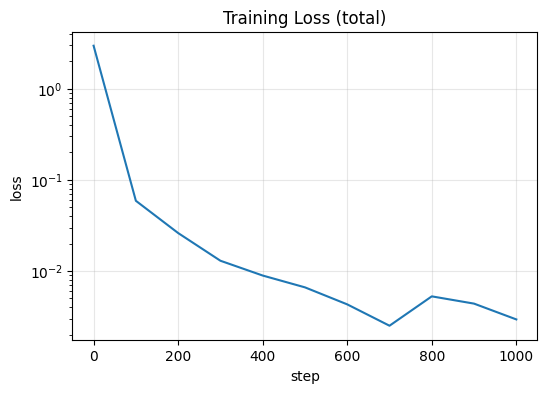

In [159]:
# --- 손실 그래프 그리기 (CSV 기준) ------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_path)  # 위에서 찍힌 경로 사용
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"])
plt.yscale("log")  # ← 요기!
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss (total)")
plt.grid(True, alpha=0.3)
plt.show()

### 학습 결과

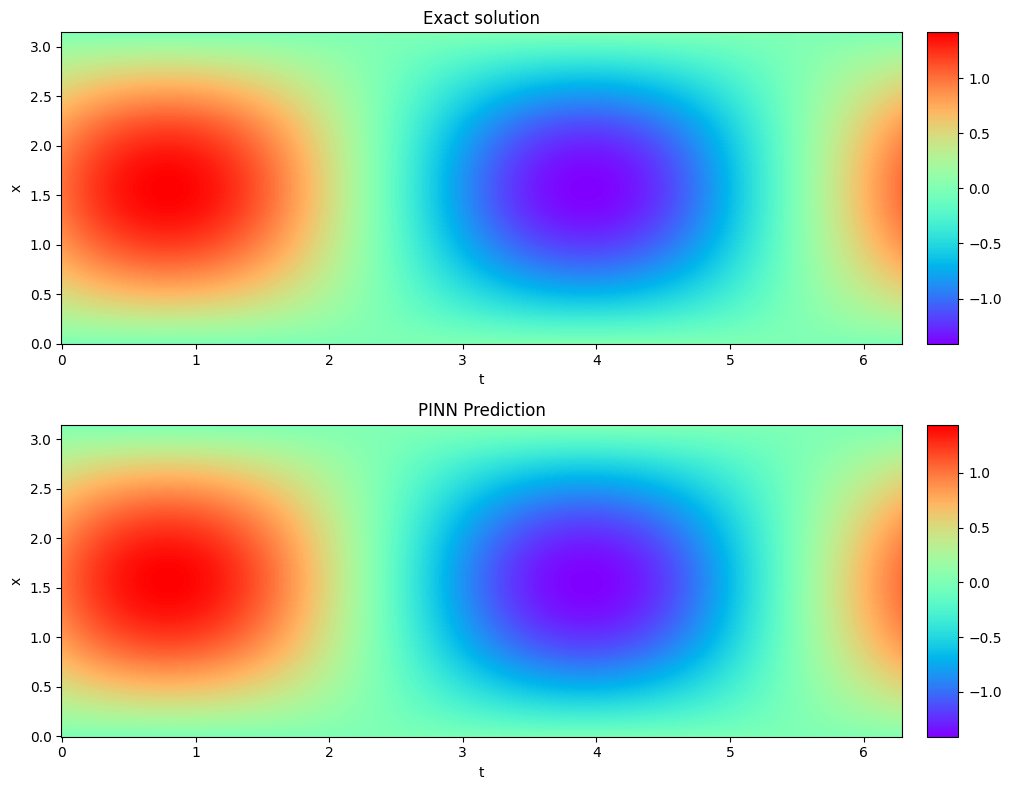

In [157]:
# =========================
# 결과 Plot
#     - GT: u(x,t) = sin(x) * (sin(t) + cos(t))
#     - Pred: 체크포인트 로드 후 그리드 예측
# =========================
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# (9-1) 평가 격자 및 정답 생성
deltaX = 0.01
deltaT = 0.01
xv = np.arange(0.0, L, deltaX)
tv = np.arange(0.0, 2.0 * L, deltaT)
T, X = np.meshgrid(tv, xv, indexing="ij")   # (Nt, Nx)

u_true = np.sin(X) * (np.sin(T) + np.cos(T))  # Analytical solution

# (9-2) 동일 아키텍처로 추론 네트워크 만들고 가중치 로드
u_net_star = instantiate_arch(
    input_keys=[Key("x"), Key("t")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)

ckpt_path = os.path.join(cfg.network_dir, "u_network.0.pth")
state = torch.load(ckpt_path, map_location="cpu")
u_net_star.load_state_dict(state)
u_net_star.eval()

# (9-3) 예측 수행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u_net_star.to(device)

with torch.no_grad():
    inp = {
        "x": torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device),
        "t": torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device),
    }
    out = u_net_star(inp)
    u_pred = out["u"].detach().cpu().numpy().reshape(T.shape)  # (Nt, Nx)

# (9-4) Plot (정답 vs 예측)
fig = plt.figure(figsize=(11, 8))
gs = GridSpec(2, 1)

# Exact
ax1 = plt.subplot(gs[0, 0])
pc1 = ax1.pcolormesh(T, X, u_true, shading="auto", cmap="rainbow")
ax1.set_xlabel("t"); ax1.set_ylabel("x"); ax1.set_title("Exact solution")
cbar1 = plt.colorbar(pc1, ax=ax1, pad=0.025, aspect=10)

# Predict
ax2 = plt.subplot(gs[1, 0])
pc2 = ax2.pcolormesh(T, X, u_pred, shading="auto", cmap="rainbow")
ax2.set_xlabel("t"); ax2.set_ylabel("x"); ax2.set_title("PINN Prediction")
cbar2 = plt.colorbar(pc2, ax=ax2, pad=0.025, aspect=10)

plt.tight_layout()
plt.show()

# 2D Lid Driven Cavity

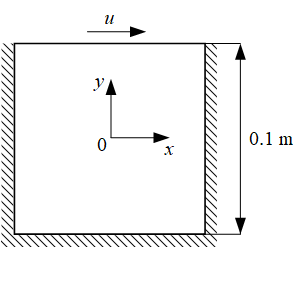

## Lid Driven Cavity problem : Navier-Stokes 정의

In [177]:
from physicsnemo.sym.eq.pdes.navier_stokes import NavierStokes

In [178]:
# ===========================================
# PDE (Navier–Stokes, steady)
# ===========================================
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

### Load Configuration

In [179]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, open_dict

In [180]:
%cd /content/physicsnemo_tutorial/PINNs/2D_LDC/conf/
%mkdir /tmp/conf
%cp config_2D_ldc.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_2D_ldc"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/2D_LDC/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


In [181]:
with open_dict(cfg):
    cfg.network_dir = "outputs_2D_LDC"
    cfg.training.max_steps = 1000 # 10000
print(OmegaConf.to_yaml(cfg))

%cd /content

training:
  max_steps: 1000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  grad_clip_max_norm: 0.5
  monitor_grad_clip: true
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
amp:
  enabled: false
  mode: per_order_scaler
  dtype: float16
  autocast_activation: false
  autocast_firstlayer: false
  default_max_scale_log2: 0
  custom_max_scales_log2: {}
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs_2D_LDC
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: 'off'
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: t

In [182]:
import re
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
from sympy import Symbol, Eq, Abs, Symbol as SymSymbol

## 학습 모델 정의
- physicsnemo의 fully connected MLP모델로 정의합니다.

In [183]:
from physicsnemo.sym.hydra import instantiate_arch

In [184]:
flow_net = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    cfg=cfg.arch.fully_connected,
)

- node를 통해 PDE와 Network를 하나로 묶어줍니다.

In [185]:
nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

## 학습 도메인 및 제약 조건 설정
- physicsnemo geometry, domain, constraint를 통해 정의합니다.

In [ ]:
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.key import Key
from physicsnemo.sym.geometry.primitives_2d import Rectangle
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)

In [186]:
# ===========================================
# Domain / Geometry
# ===========================================
width = 0.1
height = 0.1
x, y = Symbol("x"), Symbol("y")
rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

# 도메인 컨테이너
ldc_domain = Domain()

In [187]:
# ===========================================
# Constraints (Top lid / No-slip / Interior)
#    - Top wall: (u=U, v=0) with edge-weakening
#    - No-slip(그 외 벽): (u=0, v=0)
#    - Interior: continuity=0, momentum_x=0, momentum_y=0
# ===========================================
lid_u = 1.0  # 상단 뚜껑 속도

# Top wall (y = +h/2)
top_wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": lid_u, "v": 0.0},
    batch_size=cfg.batch_size.TopWall,
    # 모서리에서 u 가중치를 0으로 줄여 수치적 안정성 향상
    lambda_weighting={"u": 1.0 - 20.0 * Abs(x), "v": 1.0},
    criteria=Eq(y, height / 2),
    batch_per_epoch=1,
)
ldc_domain.add_constraint(top_wall, "top_wall")

# No-slip (상단 제외한 나머지 경계)
no_slip = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 0.0, "v": 0.0},
    batch_size=cfg.batch_size.NoSlip,
    criteria=y < height / 2,   # 경계 샘플 중 상단(y=+h/2) 제외
    batch_per_epoch=1,
)
ldc_domain.add_constraint(no_slip, "no_slip")

# Interior (잔차 = 0), SDF 가중치 사용
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"continuity": 0.0, "momentum_x": 0.0, "momentum_y": 0.0},
    batch_size=cfg.batch_size.Interior,
    lambda_weighting={
        "continuity": SymSymbol("sdf"),
        "momentum_x": SymSymbol("sdf"),
        "momentum_y": SymSymbol("sdf"),
    },
    batch_per_epoch=1,
)
ldc_domain.add_constraint(interior, "interior")

[INFO] physicsnemo.sym.graph: Arch Node: flow_network has been converted to a FuncArch node.
Arch Node: flow_network has been converted to a FuncArch node.


### Loss graph PostProcessing Code - Train Logger에 부착

In [ ]:
from physicsnemo.sym.solver import Solver

In [188]:
# ===========================================
# 6) (선택) 손실 CSV/NPZ 로거
#    - physicsnemo.sym.trainer 로그 파싱 → CSV/NPZ 저장
# ===========================================
class TrainerLossLogger(logging.Handler):
    _pat = re.compile(
        r"\[step:\s*(\d+)\]\s+loss:\s+([0-9eE\+\-\.]+)(?:,\s*time/iteration:\s*([0-9eE\+\-\.]+)\s*ms)?"
    )
    def __init__(self, out_dir, csv_name="loss_log.csv", npz_name="loss_history.npz"):
        super().__init__(level=logging.INFO)
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.csv_path = os.path.join(out_dir, csv_name)
        self.npz_path = os.path.join(out_dir, npz_name)
        self.steps, self.losses, self.times = [], [], []
        self._last_step = None
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["step", "loss", "time_ms"])

    def emit(self, record):
        m = self._pat.search(record.getMessage())
        if not m:
            return
        step = int(m.group(1))
        loss = float(m.group(2))
        t_ms = float(m.group(3)) if m.group(3) is not None else ""
        if self._last_step == step:
            return
        self._last_step = step
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, loss, t_ms])
        self.steps.append(step)
        self.losses.append(loss)
        self.times.append(np.nan if t_ms == "" else float(t_ms))

    def save_npz(self):
        np.savez(self.npz_path,
                 step=np.array(self.steps, dtype=np.int64),
                 loss=np.array(self.losses, dtype=np.float64),
                 time_ms=np.array(self.times, dtype=np.float64))
        return self.npz_path, self.csv_path

trainer_logger = logging.getLogger("physicsnemo.sym.trainer")
loss_logger = TrainerLossLogger(out_dir=cfg.network_dir)
trainer_logger.addHandler(loss_logger)

### 학습 시작

In [189]:
# ===========================================
# 7) Solver 실행
# ===========================================
slv = Solver(cfg, ldc_domain)
slv.solve()

[WARNING] physicsnemo.sym.trainer: Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/outputs_2D_LDC
attempting to restore from: /content/outputs_2D_LDC
[INFO] physicsnemo.sym.trainer: Success loading optimizer: /content/outputs_2D_LDC/optim_checkpoint.0.pth
Success loading optimizer: /content/outputs_2D_LDC/optim_checkpoint.0.pth
[INFO] physicsnemo.sym.trainer: Success loading model: /content/outputs_2D_LDC/flow_network.0.pth
Success loading model: /content/outputs_2D_LDC/flow_netw

In [190]:
npz_path, csv_path = loss_logger.save_npz()
trainer_logger.removeHandler(loss_logger)
print(f"[saved] {csv_path}\n[saved] {npz_path}")

[saved] outputs_2D_LDC/loss_log.csv
[saved] outputs_2D_LDC/loss_history.npz


### Loss graph

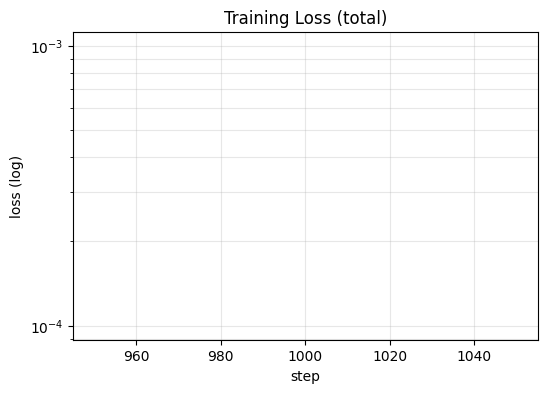

In [191]:
# ===========================================
# Loss 그래프 (로그 스케일)
# ===========================================
import pandas as pd
df = pd.read_csv(csv_path)
eps = 1e-12
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"].clip(lower=eps))
plt.yscale("log")
plt.xlabel("step"); plt.ylabel("loss (log)")
plt.title("Training Loss (total)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

### 학습 결과

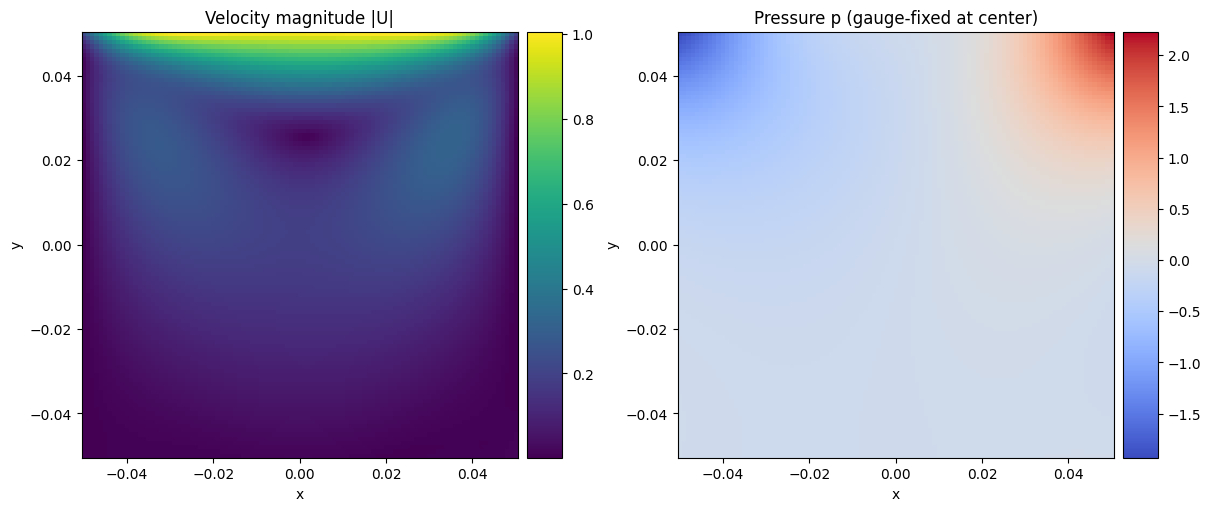

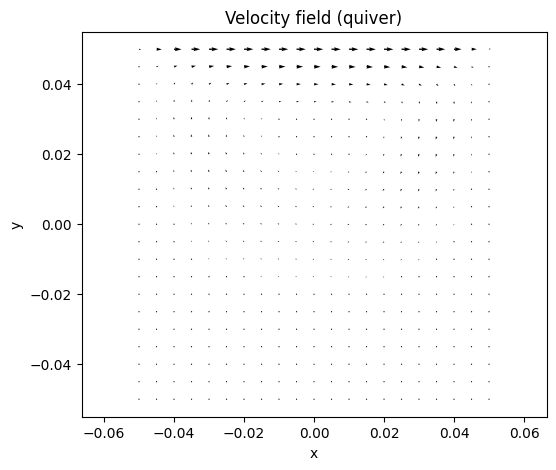

In [192]:
# ===========================================
# 결과 플롯: 속도 크기 |U|, 압력 p, 벡터장(간략 quiver)
# ===========================================
# 동일 아키텍처로 추론 네트워크 구성 + 가중치 로드
flow_net_star = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    cfg=cfg.arch.fully_connected,
)
ckpt_path = os.path.join(cfg.network_dir, "flow_network.0.pth")
state = torch.load(ckpt_path, map_location="cpu")
flow_net_star.load_state_dict(state)
flow_net_star.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flow_net_star.to(device)

# 균일 격자 샘플
NX = NY = 101
xs = np.linspace(-width/2, width/2, NX)
ys = np.linspace(-height/2, height/2, NY)
YY, XX = np.meshgrid(ys, xs, indexing="ij")  # (NY, NX)
with torch.no_grad():
    inp = {
        "x": torch.tensor(XX.reshape(-1,1), dtype=torch.float32, device=device),
        "y": torch.tensor(YY.reshape(-1,1), dtype=torch.float32, device=device),
    }
    out = flow_net_star(inp)
    U = out["u"].detach().cpu().numpy().reshape(NY, NX)
    V = out["v"].detach().cpu().numpy().reshape(NY, NX)
    P = out["p"].detach().cpu().numpy().reshape(NY, NX)
speed = np.sqrt(U**2 + V**2)

# 플롯: |U|와 p
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

pc0 = axes[0].pcolormesh(XX, YY, speed, shading="auto", cmap="viridis")
axes[0].set_title("Velocity magnitude |U|")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
plt.colorbar(pc0, ax=axes[0], pad=0.02, aspect=12)

pc1 = axes[1].pcolormesh(XX, YY, P, shading="auto", cmap="coolwarm")
axes[1].set_title("Pressure p (gauge-fixed at center)")
axes[1].set_xlabel("x"); axes[1].set_ylabel("y")
plt.colorbar(pc1, ax=axes[1], pad=0.02, aspect=12)

plt.show()

# 벡터장(간단 quiver, 간격 축소)
step = 5
plt.figure(figsize=(6,5))
plt.quiver(XX[::step, ::step], YY[::step, ::step],
           U[::step, ::step], V[::step, ::step], scale=50)
plt.title("Velocity field (quiver)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.show()